In [6]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import re, string
import spacy
import os, random
import pickle

import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter

In [7]:
# --- Setup and Data Loading ---
# Download necessary NLTK data for stopwords and lemmatization
try:
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/omw-1.4')
    nltk.data.find('corpora/stopwords')
except:
    print("Downloading necessary NLTK data...")
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('stopwords')
    nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
# Loading the data
df = pd.read_csv('/sample30.csv')
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [9]:
# Create the result and output directory
result_dir_path = "results"
output_dir_path = "outputs"
os.makedirs(result_dir_path, exist_ok=True)
os.makedirs(output_dir_path, exist_ok=True)

# PART 1: SENTIMENT ANALYSIS MODEL


### *** Exploratory Data Analysis (EDA) ***

In [10]:
print("\n## 1. Initial Data Exploration")
print("DataFrame Info:")
df.info()
print("\nValue Counts of user_sentiment:")
print(df['user_sentiment'].value_counts())


## 1. Initial Data Exploration
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  

/tmp/ipython-input-2014549417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='user_sentiment', data=df, palette='viridis', order=df['user_sentiment'].value_counts().index)


Text(0, 0.5, 'Count')

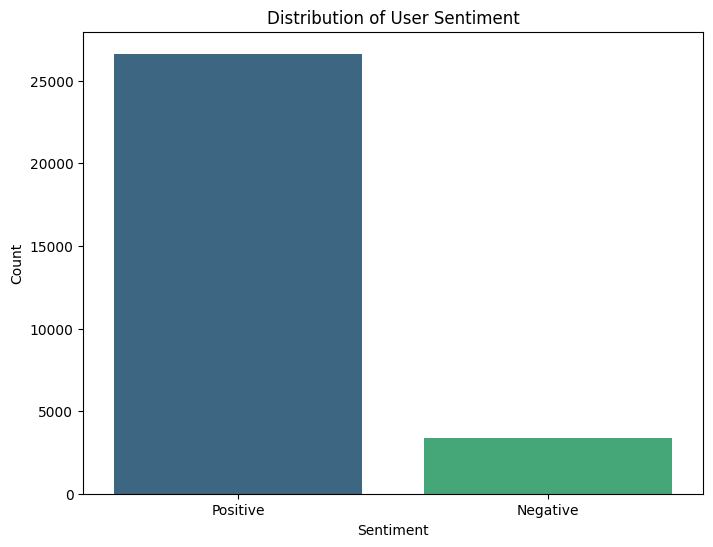

In [11]:
# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='user_sentiment', data=df, palette='viridis', order=df['user_sentiment'].value_counts().index)
plt.title('Distribution of User Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')


###### In the above graph we can observe a high "CLASS IMBALANCE" problem. The no. of positives is very high compared to negatives

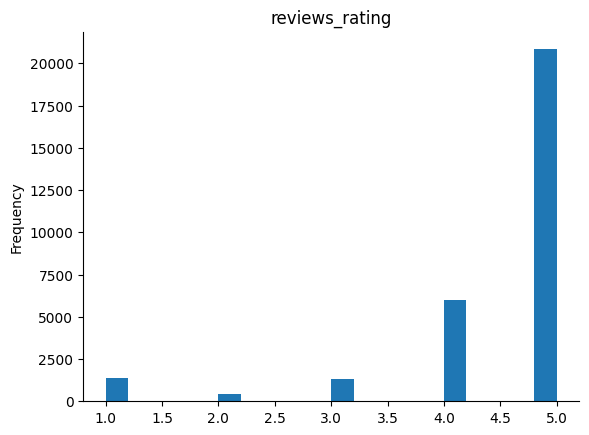

In [12]:
# Visualize Reviews Ratings
from matplotlib import pyplot as plt
df['reviews_rating'].plot(kind='hist', bins=20, title='reviews_rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

##### Same pattern observed in the above plot. More Higher ratings than Lower ratings

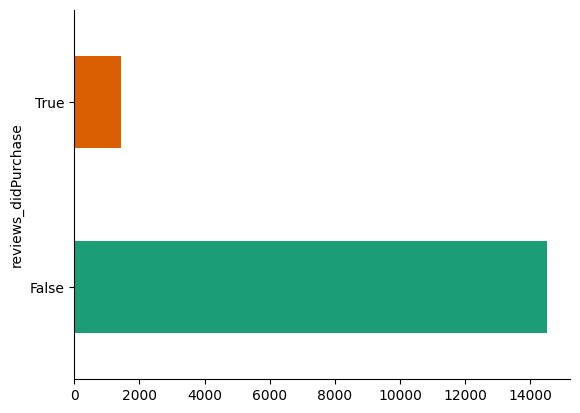

In [13]:
# Visualize reviews_didPurchase column

df.groupby('reviews_didPurchase').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

##### Interestingly, most of the people who gave ratings and reviews, did not purchase the product.

# Task 1 : Data Cleaning and Pre-Processing

In [14]:
# Assign meaningful column names
cleaned_df = df.rename(columns={"name" : "product"})

In [15]:
# Selecting only relevant columns and Removing all the unnecessary columns

# For the complete analysis, we need only "product name", "reviews_username", "reviews_rating", "reviews_text", "user_sentiment"
cleaned_df = cleaned_df[[ "reviews_username", "product", "reviews_rating", "reviews_text", "user_sentiment"]]
cleaned_df.head()

,reviews_username,product,reviews_rating,reviews_text,user_sentiment
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Positive
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Positive
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Positive
3,rebecca,K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Negative
4,walker557,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Negative


In [16]:
# checking missing values
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  29937 non-null  object
 1   product           30000 non-null  object
 2   reviews_rating    30000 non-null  int64 
 3   reviews_text      30000 non-null  object
 4   user_sentiment    29999 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [17]:
# Remove all rows where username column is nan - Since we need the "user name" to recommend products to a particular User
cleaned_df = cleaned_df.dropna(subset=["reviews_username"])
cleaned_df.shape

(29937, 5)

In [18]:
# "user_sentiment" is having missing values. Since Rating more than 3 would ideally mean a positive sentiment, we make the below imputation
## Fill user_sentiment as Positive if rating is greater than 3, otherwise False
positive_sentiment = cleaned_df["reviews_rating"] > 3
cleaned_df.loc[positive_sentiment, "user_sentiment"] = "Positive"

negative_sentiment = cleaned_df["reviews_rating"] < 3
cleaned_df.loc[negative_sentiment, "user_sentiment"] = "Negative"

cleaned_df.shape

(29937, 5)

In [19]:
# missing values handled
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29937 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  29937 non-null  object
 1   product           29937 non-null  object
 2   reviews_rating    29937 non-null  int64 
 3   reviews_text      29937 non-null  object
 4   user_sentiment    29937 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


# Task 2 : Text Processing
#### Performing Lemmatization and removing stop words.
#### Lemmatization would help in bringing all the similar words to the same Lemma
#### Stop words removal will help us remove any irrelevant words from the analysis

In [20]:
# prepare to Lemmatize and Remove stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [21]:
# function to perform text processing (Lemmatize and Remove stop words)
def process_text(text):
    """Cleans and processes text data."""
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    # Apply lemmatization and remove stopwords
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)

In [22]:
# Apply processing to the reviews
processed_df = cleaned_df.copy()
processed_df['processed_text'] = processed_df['reviews_text'].apply(process_text)
processed_df.head()

,reviews_username,product,reviews_rating,reviews_text,user_sentiment,processed_text
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Positive,love album good hip hop side current pop sound...
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Positive,good flavor review collected part promotion
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Positive,good flavor
3,rebecca,K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Negative,read review looking buying one couple lubrican...
4,walker557,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Negative,husband bought gel u gel caused irritation fel...


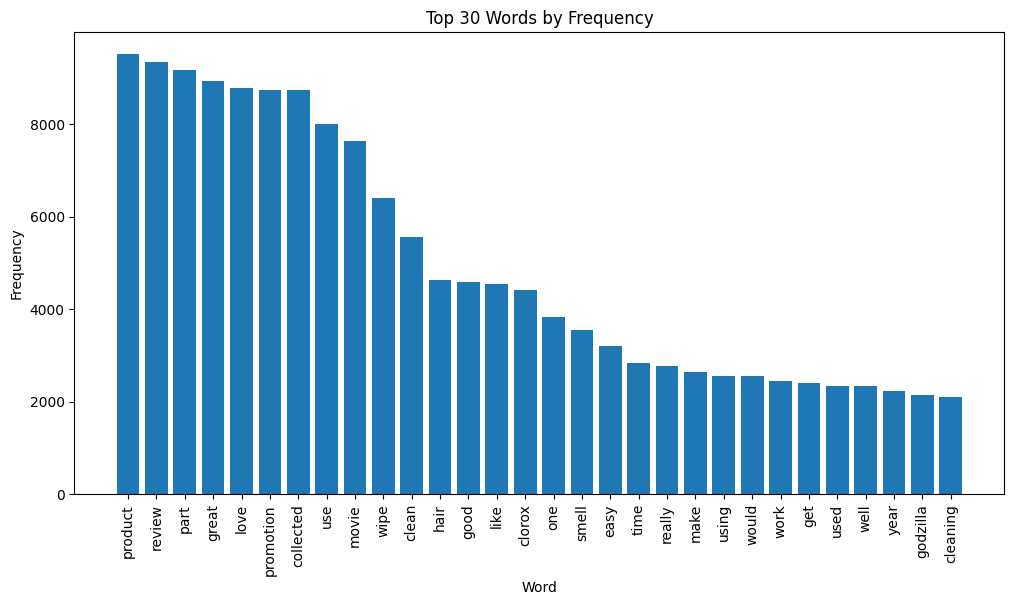

In [23]:
# Find the top 30 words by frequency among all the reviews after processing the text
all_words = [word for review in processed_df["processed_text"] for word in review.split()]

# Get the top 30 most common words
word_freq = Counter(all_words).most_common(30)
(words, counts) = zip(*word_freq)

# Plot the top 30 most common words
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Top 30 Words by Frequency")
plt.xticks(rotation=90)
plt.show()

# Task 3 : Feature Extraction
#### Converting text form to numerical form using TF-IDF, as ML models can only understand numbers

In [24]:
#### Converting user_sentiment into numbers
X = processed_df['processed_text']
# Encode target labels: Positive -> 1, Negative -> 0
y = processed_df['user_sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

# Create TF-IDF vectors from the text
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into training and testing sets. Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Data split into training and testing sets. Training set shape: (23949, 5000)
Testing set shape: (5988, 5000)


In [25]:
# Save the tfidf vectorizer into the outputs directory
with open(output_dir_path + "/tfidf_vectorizer.pkl", 'wb') as files:
    pickle.dump(tfidf_vectorizer, files)

# Task 4 : Sentiment analysis Model building

### Handling class-imbalance problem

In [26]:
# Resample the data to have equal positive and negative samples for model building
count = Counter(y_train)
print('Before sampling :', count)

# Initialize sampler and resample
sampler = SMOTE(random_state=23)
X_train_sm, y_train_sm = sampler.fit_resample(X_train, y_train)

count = Counter(y_train_sm)
print('After sampling :',count)

Before sampling : Counter({1: 22341, 0: 1608})
After sampling : Counter({1: 22341, 0: 22341})


### Model 1 : Logistic Regression
This model is computationally efficient and easy to interpret.



In [27]:
# Train and Evaluate Logistic Regression
print("\n--- Training and Evaluating Logistic Regression on Test data ---")

# Initialize the model
lr_model = LogisticRegression(random_state=42, solver='liblinear')

# Train the model on the TF-IDF vectorized training data
lr_model.fit(X_train, y_train)

# Make predictions on the test set
lr_y_pred = lr_model.predict(X_test)

# Calculate and store the evaluation metrics
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_report = classification_report(y_test, lr_y_pred, target_names=['Negative', 'Positive'])

# Print the results
print(f"Accuracy: {lr_accuracy:.4f}")
print("Classification Report:")
print(lr_report)


--- Training and Evaluating Logistic Regression on Test data ---
Accuracy: 0.9628
Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.48      0.63       402
    Positive       0.96      1.00      0.98      5586

    accuracy                           0.96      5988
   macro avg       0.95      0.74      0.81      5988
weighted avg       0.96      0.96      0.96      5988



In [28]:
# save the logistic regression model in results path
with open(result_dir_path + "/lr_model.pkl", 'wb') as files:
    pickle.dump(lr_model, files)

### Model 2 : Random Forest
It's known for its high accuracy and ability to handle non-linear relationships.

In [29]:
# Train and Evaluate Random Forest
print("\n--- Training and Evaluating Random Forest on Test data---")

# Initialize the model with 100 decision trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the ensemble model
rf_model.fit(X_train, y_train)

# Make predictions
rf_y_pred = rf_model.predict(X_test)

# Calculate and store the evaluation metrics
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_report = classification_report(y_test, rf_y_pred, target_names=['Negative', 'Positive'])

# Print the results
print(f"Accuracy: {rf_accuracy:.4f}")
print("Classification Report:")
print(rf_report)


--- Training and Evaluating Random Forest on Test data---
Accuracy: 0.9644
Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.51      0.66       402
    Positive       0.97      1.00      0.98      5586

    accuracy                           0.96      5988
   macro avg       0.95      0.75      0.82      5988
weighted avg       0.96      0.96      0.96      5988



In [30]:
# save the random forest model in results path
with open(result_dir_path + "/rf_model.pkl", 'wb') as files:
    pickle.dump(rf_model, files)

### Model 3 : XGBoost Model
Powerful and popular algorithm for its speed and performance.

In [31]:
# Train and Evaluate XGBoost
print("\n--- Training and Evaluating XGBoost on Test data ---")

# Initialize the model. `use_label_encoder=False` is set to avoid a warning.
# `eval_metric='logloss'` specifies the evaluation metric for binary classification.
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_y_pred = xgb_model.predict(X_test)

# Calculate and store the evaluation metrics
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_report = classification_report(y_test, xgb_y_pred, target_names=['Negative', 'Positive'])

# Print the results
print(f"Accuracy: {xgb_accuracy:.4f}")
print("Classification Report:")
print(xgb_report)


--- Training and Evaluating XGBoost on Test data ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:30:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9648
Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.55      0.68       402
    Positive       0.97      0.99      0.98      5586

    accuracy                           0.96      5988
   macro avg       0.92      0.77      0.83      5988
weighted avg       0.96      0.96      0.96      5988



In [32]:
# save the XGBoost model in results path
with open(result_dir_path + "/xgb_model.pkl", 'wb') as files:
    pickle.dump(xgb_model, files)

### Choosing *XGBoost* as the final algorithm as it shows great potential in terms of accuracy, precison and F1 score. Recall can be improved.
### *** Detailed comparison *** : While Logistic Regression provides a great baseline and is highly interpretable, XGBoost's superior performance (often reflected in higher accuracy and F1-scores) makes it the winner for a classification task where predictive power is the primary goal. Random Forest is also a strong contender, but XGBoost's optimized implementation and boosting approach often give it a slight edge in terms of both speed and performance.

## Fine-tuning the XGBoost model

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Initialize the XGBoost model
xgb_model_base = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV.
# cv=5 : 5-fold cross-validation will be used
grid_search = GridSearchCV(estimator=xgb_model_base,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

print("\n--- Starting XGBoost Hyperparameter Tuning with GridSearchCV ---")

# Fit the grid search to the data.
grid_search.fit(X_train, y_train)

# Print the best parameters found by the search
print("\nBest Parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Get the best estimator (the model with the best parameters)
best_xgb_model = grid_search.best_estimator_

# Make predictions using the tuned model
tuned_xgb_y_pred = best_xgb_model.predict(X_test)

# Calculate and print the metrics for the tuned model
tuned_xgb_accuracy = accuracy_score(y_test, tuned_xgb_y_pred)
tuned_xgb_report = classification_report(y_test, tuned_xgb_y_pred, target_names=['Negative', 'Positive'], output_dict=True)

print(f"Accuracy: {tuned_xgb_accuracy:.4f}")
print("Classification Report:")
print(tuned_xgb_report)



--- Starting XGBoost Hyperparameter Tuning with GridSearchCV ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:01:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters found by GridSearchCV:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Accuracy: 0.9658
Classification Report:
{'Negative': {'precision': 0.8893280632411067, 'recall': 0.5597014925373134, 'f1-score': 0.6870229007633588, 'support': 402.0}, 'Positive': {'precision': 0.9691368788142982, 'recall': 0.9949874686716792, 'f1-score': 0.9818920590053882, 'support': 5586.0}, 'accuracy': 0.9657648630594522, 'macro avg': {'precision': 0.9292324710277025, 'recall': 0.7773444806044962, 'f1-score': 0.8344574798843736, 'support': 5988.0}, 'weighted avg': {'precision': 0.9637789723579818, 'recall': 0.9657648630594522, 'f1-score': 0.9620962337526667, 'support': 5988.0}}


In [33]:
# Final XGBoost model - Best Parameters found by GridSearchCV: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
final_xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',
                                learning_rate=0.2, max_depth=5, n_estimators=300)

# Train and Evaluate final XGBoost
print("\n--- Training and Evaluating final XGBoost on Test data ---")

# Train the model
final_xgb_model.fit(X_train, y_train)

# Make predictions
xgb_y_pred = final_xgb_model.predict(X_test)

# Calculate and store the evaluation metrics
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_report = classification_report(y_test, xgb_y_pred, target_names=['Negative', 'Positive'])

# Print the results
print(f"Accuracy: {xgb_accuracy:.4f}")
print("Classification Report:")
print(xgb_report)


--- Training and Evaluating final XGBoost on Test data ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:31:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9659
Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.56      0.69       402
    Positive       0.97      1.00      0.98      5586

    accuracy                           0.97      5988
   macro avg       0.93      0.78      0.84      5988
weighted avg       0.96      0.97      0.96      5988



In [34]:
# Save the final tuned XGBoost model
with open(result_dir_path + "/final_xgb_model.pkl", 'wb') as files:
    pickle.dump(final_xgb_model, files)

# PART 2 : RECOMMENDATION SYSTEM

## Task 5 : Building the Recommendation System

In [35]:
# Data Preparation
recsys_df = cleaned_df[['reviews_username', 'product', 'reviews_rating']].copy()
recsys_df.dropna(inplace=True)

# Group by dataframe by username and product, and find the mean of ratings provided
recsys_df = recsys_df.groupby(['reviews_username', 'product'])['reviews_rating'].mean().reset_index()
recsys_df.head()


,reviews_username,product,reviews_rating
0,00dog3,Chex Muddy Buddies Brownie Supreme Snack Mix,4.0
1,00sab00,Mike Dave Need Wedding Dates (dvd + Digital),1.0
2,00sab00,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,3.0
3,01impala,Godzilla 3d Includes Digital Copy Ultraviolet ...,3.0
4,02dakota,Godzilla 3d Includes Digital Copy Ultraviolet ...,5.0


In [36]:
# Test and Train split of the dataset.
train, test = train_test_split(recsys_df, test_size=0.20, random_state=42)
print(train.shape)
print(test.shape)

(22070, 3)
(5518, 3)


In [37]:
# Build User-Item Matrix for train data
df_pivot = train.pivot(
    index='reviews_username',
    columns='product',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

product,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset
These dataset will be used for prediction
- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [38]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [39]:
# The products not rated by user is marked as 1 for prediction.
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [40]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='product',
    values='reviews_rating'
).fillna(1)

In [41]:
dummy_train.head()

product,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Model 1 : User-Based Collaborative Filtering

In [42]:
## Using adjusted Cosine
### Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

### Normalising the rating of the product for each user around 0 mean
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

product,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,...,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625
00sab00,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,...,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625
02dakota,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,...,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531
02deuce,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,...,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625,-0.015625
06stidriver,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,...,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531,-0.019531


In [43]:
### Finding adjusted cosine similarity
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.         -0.00496628 -0.00392157 ... -0.00392157 -0.00392157
  -0.00392157]
 [-0.00496628  1.         -0.00496628 ... -0.00496628  0.9485598
  -0.00496628]
 [-0.00392157 -0.00496628  1.         ... -0.00392157 -0.00392157
  -0.00392157]
 ...
 [-0.00392157 -0.00496628 -0.00392157 ...  1.         -0.00392157
   1.        ]
 [-0.00392157  0.9485598  -0.00392157 ... -0.00392157  1.
  -0.00392157]
 [-0.00392157 -0.00496628 -0.00392157 ...  1.         -0.00392157
   1.        ]]


In [44]:
## Prediction - User User
### Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.
user_correlation[user_correlation<0]=0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.9485598,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.       , 0.9485598, 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [45]:
# Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings
user_predicted_ratings.shape

(20257, 256)

In [46]:
# Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

product,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.453948,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
00sab00,0.0,3.145612,0.0,0.0,2.720272,0.0,0.0,0.0,0.0,6.004111,...,2.956054,0.0,1.243805,1.833106,0.0,0.0,0.0,14.550190,2.720272,1.115768
02dakota,0.0,32.925451,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,13.270904,...,1.806856,0.0,2.126591,1.420900,0.0,0.0,0.0,29.102075,0.000000,2.453948
02deuce,0.0,32.925451,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,13.270904,...,1.806856,0.0,2.126591,1.420900,0.0,0.0,0.0,29.102075,0.000000,2.453948
06stidriver,0.0,7.809992,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,7.379785,...,0.000000,0.0,2.875408,0.000000,0.0,0.0,0.0,3.895666,0.000000,0.000000


### Finding the top 20 product recommendations for a *user*

In [47]:
# Take the user ID as input.
user_input = input("Enter your user name: ")
print(f"Sample user: {user_input}" )
user_final_rating.head(2)
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

Enter your user name: joshua
Sample user: joshua


,joshua
product,
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,41.589068
The Resident Evil Collection 5 Discs (blu-Ray),16.284729
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),15.781612
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),14.738821
Mike Dave Need Wedding Dates (dvd + Digital),14.335824
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8.195800
"Hormel Chili, No Beans",7.001260
100:Complete First Season (blu-Ray),6.483790
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),6.318053


In [48]:
# Evaluation - User User
### Evaluation will we same as we have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape
common.head()

,reviews_username,product,reviews_rating
6593,dani,Mike Dave Need Wedding Dates (dvd + Digital),5.0
12463,john,Mike Dave Need Wedding Dates (dvd + Digital),4.0
10935,jack,Godzilla 3d Includes Digital Copy Ultraviolet ...,4.0
11072,james,Mike Dave Need Wedding Dates (dvd + Digital),4.0
17342,mhayser,Clorox Disinfecting Bathroom Cleaner,5.0


In [49]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='product', values='reviews_rating')

# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)

In [50]:
# getting list of all the common users in train and test
list_name = common.reviews_username.tolist()
user_correlation_df.columns = df_subtracted.index.tolist()

# Selecting only the Users common between train and test
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T

# since any correlation less than 0 is not relevant to us, we make all such cases as 0
user_correlation_df_3[user_correlation_df_3<0]=0

# get the predicted ratings for the products as per the weightage of the users
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 6.97606773, 0.        ,
        0.46327395],
       [0.        , 0.        , 1.01863279, ..., 6.91295162, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.91295162, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.70571894, 0.        ,
        0.        ],
       [0.        , 0.        , 5.        , ..., 2.72684914, 4.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.91295162, 0.        ,
        0.70571894]])

In [51]:
# Pre-processing the dummy_test data
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

# Convert the dummy test dataset into matrix format.
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='product', values='reviews_rating').fillna(0)
dummy_test.shape

(715, 114)

In [52]:
# get the predicted ratings for the products which have been rated already to evaluate the model
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head(2)

product,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Various - Country's Greatest Gospel:Gold Ed (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.
X  = common_user_predicted_ratings.copy()
X = X[X>0]

# normalize using min max scaler
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

common_ = common.pivot_table(index='reviews_username', columns='product', values='reviews_rating')

# Perform element-wise subtraction.
# Any user-product pair where one DataFrame has a rating and the other has a NaN will result in a NaN in the `error` DataFrame.
error = (common_ - y)**2

# Replace all NaN values in the result with 0.
# This assumes that a NaN indicates a non-existent value that should not contribute to the overall error.
error_filled = error.fillna(0)

# Calculate the total number of non-NaN values in the original common_ DataFrame.
# This is crucial for correctly calculating the average error, as we only want to average over the actual ratings.
total_non_nan = np.count_nonzero(~np.isnan(common_))

# Calculate the RMSE.
rmse = np.sqrt(error_filled.values.sum() / total_non_nan)

print(f"RMSE: {rmse:.4f}")

MinMaxScaler(feature_range=(1, 5))
RMSE: 2.0774


## Model 2 : Item-Based Collaborative Filtering

In [54]:
## Using Item similarity
# Item Based Similarity : Taking the transpose of the rating matrix to normalize the rating around the mean for different product ID. In the user based similarity, we had taken mean for each user instead of each product.
df_pivot = train.pivot(
    index='reviews_username',
    columns='product',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
product,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Normalising the product rating for each product for using the Adujsted Cosine
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
product,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,0.28125,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Finding the cosine similarity using pairwise distances approach
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00539168  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00539168  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [57]:
# Filtering the correlation only for which the value is greater than 0. (Positively correlated)
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [58]:
# Prediction - Item Item
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
print(item_predicted_ratings)
print(f"item_predicted_ratings : {item_predicted_ratings.shape}")
print(f"dummy_train : {dummy_train.shape}")

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.02534873 0.         ... 0.         0.00465735 0.        ]
 [0.         0.01223852 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0320542  0.         ... 0.         0.00776225 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
item_predicted_ratings : (20257, 256)
dummy_train : (20257, 256)


In [59]:
### Filtering the rating only for the products not rated by the user for recommendation
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

product,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
00sab00,0.0,0.025349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005551,...,0.000000,0.0,0.000000,0.009850,0.0,0.0,0.0,0.0,0.004657,0.0
02dakota,0.0,0.012239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.017503,0.0,0.009964,0.004552,0.0,0.0,0.0,0.0,0.000000,0.0
02deuce,0.0,0.009791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.014002,0.0,0.007971,0.003642,0.0,0.0,0.0,0.0,0.000000,0.0
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000519,...,0.000000,0.0,0.005254,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


### Finding the top 20 product recommendations for a *user*

In [60]:
# Take the user ID as input
user_input = input("Enter your user name : ")
print(user_input)

# Recommending the Top 20 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

Enter your user name : joshua
joshua


,joshua
product,
"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",0.106628
Chester's Cheese Flavored Puffcorn Snacks,0.102573
Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,0.068989
Spam Single Classic,0.059607
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),0.056172
Olivella Bar Soap - 3.52 Oz,0.040360
100:Complete First Season (blu-Ray),0.033918
Jason Aldean - They Don't Know,0.032095
Jolly Time Select Premium Yellow Pop Corn,0.030781


In [61]:
# Evaluation - Item Item
## Evaluation will we same as we have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.
common =  test[test["product"].isin(train["product"])]
common.head(4)

,reviews_username,product,reviews_rating
11402,jc,"Pendaflex174 Divide It Up File Folder, Multi S...",5.0
14316,krissywill,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
20637,picardrc,Godzilla 3d Includes Digital Copy Ultraviolet ...,4.0
11373,jbeeks,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0


In [62]:
# convert into the user-product matrix
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='product', values='reviews_rating').T
common_item_based_matrix.shape

(189, 5359)

In [63]:
# Convert the item_correlation matrix into dataframe.
item_correlation_df = pd.DataFrame(item_correlation)

item_correlation_df['product'] = df_subtracted.index
item_correlation_df.set_index('product',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
product,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# getting list of all the common items in train and test
list_name = common["product"].tolist()
item_correlation_df.columns = df_subtracted.index.tolist()

In [65]:
# Selecting only the Items common between train and test
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
product,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# since any correlation less than 0 is not relevant to us, we make all such cases as 0
item_correlation_df_3[item_correlation_df_3<0]=0

In [67]:
# get the predicted ratings for the products as per the weightage of the common items
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00734311, 0.        , 0.00979081, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [68]:
## Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train

# Pre-processing the dummy_test data
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

# Convert the dummy test dataset into matrix format.
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='product', values='reviews_rating').T.fillna(0)

# get the predicted ratings for the products which have been rated already to evaluate the model
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

# The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.
common_ = common.pivot_table(index='reviews_username', columns='product', values='reviews_rating').T

# Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.
X  = common_item_predicted_ratings.copy()
X = X[X>0]

# normalize using min max scaler
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

# Perform element-wise subtraction.
# Any user-product pair where one DataFrame has a rating and the other has a NaN will result in a NaN in the `error` DataFrame.
error = (common_ - y)**2

# Replace all NaN values in the result with 0.
# This assumes that a NaN indicates a non-existent value that should not contribute to the overall error.
error_filled = error.fillna(0)

# Calculate the total number of non-NaN values in the original common_ DataFrame.
# This is crucial for correctly calculating the average error, as we only want to average over the actual ratings.
total_non_nan = np.count_nonzero(~np.isnan(common_))

# Calculate the RMSE.
rmse = np.sqrt(error_filled.values.sum() / total_non_nan)

print(f"RMSE: {rmse:.4f}")

MinMaxScaler(feature_range=(1, 5))
RMSE: 3.5869


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


# Recommnedation engine model selection
### Finally, By checking the root mean squared error for user-based (2.0774) and item-based (3.5877) recommendation systems. User-based recommendation will be used as it is having less RMSE.

### User-based Collaborative filtering recommendation model is selected

In [69]:
# Save user-based as the final selected recommendation system
recommendation = user_final_rating
with open(output_dir_path + "/recommendation.pkl", 'wb') as files:
    pickle.dump(recommendation, files)

### Finding the top 20 product recommendations for a *user*

In [70]:
# Take the user ID as input
user_input = input("Enter your user name : ")
print(user_input)

# Recommending the Top 20 products to the user.
d = recommendation.loc[user_input].sort_values(ascending=False)[0:20]
d

Enter your user name : joshua
joshua


,joshua
product,
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,41.589068
The Resident Evil Collection 5 Discs (blu-Ray),16.284729
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),15.781612
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),14.738821
Mike Dave Need Wedding Dates (dvd + Digital),14.335824
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8.195800
"Hormel Chili, No Beans",7.001260
100:Complete First Season (blu-Ray),6.483790
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),6.318053


# Task 7 : Fine-Tuning the Recommendation System using Sentiment analysis and Recommendation of Top 5 Products

In [71]:
# Find the top 20 recommended products for a user
def top_20_recommended_products(username):
    if username not in recommendation.index:
      return None

    product_list = recommendation.loc[username].sort_values(ascending=False)[0:20]
    print("Top 20 recommended_products for {}".format(username))
    display(product_list.index)
    print()
    products = cleaned_df[cleaned_df["product"].isin(product_list.index.tolist())]
    products = products[['product', 'reviews_text']]
    return products

In [72]:
# Fine-tune the recommended products and return products with highest positive sentiment
def top_5_products(products):
    products["review_processed"] = products["reviews_text"].apply(process_text)

    # Create TF-IDF vectors from the text
    X_tfidf = tfidf_vectorizer.transform(products["review_processed"])

    # sentiment prediction
    products['predicted_sentiment'] = final_xgb_model.predict(X_tfidf)

    total_product = products.groupby(['product']).agg('count')
    recommended_df = products.groupby(['product','predicted_sentiment']).agg('count')
    recommended_df = recommended_df.reset_index()
    merged_df = pd.merge(recommended_df, total_product['reviews_text'], on='product')
    merged_df['percentage'] = (merged_df['reviews_text_x']/merged_df['reviews_text_y'])*100
    merged_df = merged_df.sort_values(ascending=False, by='percentage')

    return list(merged_df[merged_df['predicted_sentiment'] == 1]['product'][:5])

In [73]:
# Filter top 20 recommended products then run sentiment analysis on those top 20 and recommend top 5 fine-tuned products
def final_recommend_products_to_user():
    username = input("Enter username:")
    product_list = top_20_recommended_products(username)
    if product_list is None:
        return "No products can be recommended for {}".format(username)
    else:
        products = top_5_products(product_list)
        print("Final 5 fine-tuned recommended products")
        display(products)
        print()

In [74]:
# Final products recommended for "joshua"
final_recommend_products_to_user()


Enter username:joshua
Top 20 recommended_products for joshua


Index(['Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
       'The Resident Evil Collection 5 Discs (blu-Ray)',
       'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
       'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
       'Mike Dave Need Wedding Dates (dvd + Digital)',
       'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
       'Hormel Chili, No Beans', '100:Complete First Season (blu-Ray)',
       'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
       'Chester's Cheese Flavored Puffcorn Snacks',
       'Tostitos Bite Size Tortilla Chips',
       'Clorox Disinfecting Bathroom Cleaner',
       'Jason Aldean - They Don't Know', 'Alex Cross (dvdvideo)',
       'Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)',
       'Clear Scalp & Hair Therapy Total Care Nourishing Shampoo',
       'Pleasant Hearth Diamond Fireplace Screen - Espresso',
       'Jolly Time Select Premium Yellow Pop Corn',
       '


Final 5 fine-tuned recommended products


['100:Complete First Season (blu-Ray)',
 'Jolly Time Select Premium Yellow Pop Corn',
 "Jason Aldean - They Don't Know",
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 "Meguiar's Deep Crystal Car Wash 64-Oz."]

## Task 8 : Deployment Using Flask

### The final Sentiment based recommendation engine is hosted on Heroku:

#### Link : https://capstone-recommendation-engine-092a3b5549a1.herokuapp.com/


#### GitHub link for all the other artifacts : Dataset, Pickle files for all the models, etc.
##### https://github.com/VardaanThapa/capstone_sentiment_based_product_recommendation